<a href="https://colab.research.google.com/github/T1toh/30Days_of_SQL/blob/main/MScFE_622_Stochastic_Modeling_(Team_Member_B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step *1*: Carr–Madan Calibration for Heston Model (≈15-day maturity)


---


In this step, we estimate (“calibrate”) the parameters of the Heston (1993) stochastic volatility model using the Carr–Madan (1999) Fourier transform pricing approach.

We fit model prices to observed market option prices (from our Excel file) for the SM stock with around 15 days to maturity.

This allows us to determine parameters such as:
*   Long-run variance (θ)
*   Volatility of volatility (σ)
*   Correlation between stock and variance (ρ)
*   Initial variance (v₀)
*   Mean reversion speed (κ)
*   List item



In [ ]:
import pandas as pd

# Google Sheets CSV export link
sheet_url = "https://docs.google.com/spreadsheets/d/1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR/export?format=csv"

# Load data into a DataFrame
data = pd.read_csv(sheet_url)
data.head()



,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C



 Calibrated Heston Parameters (Carr–Madan, Call Data):
kappa = 0.1000
theta = 0.0010
sigma = 1.0000
rho   = 0.9900
v0    = 0.0010


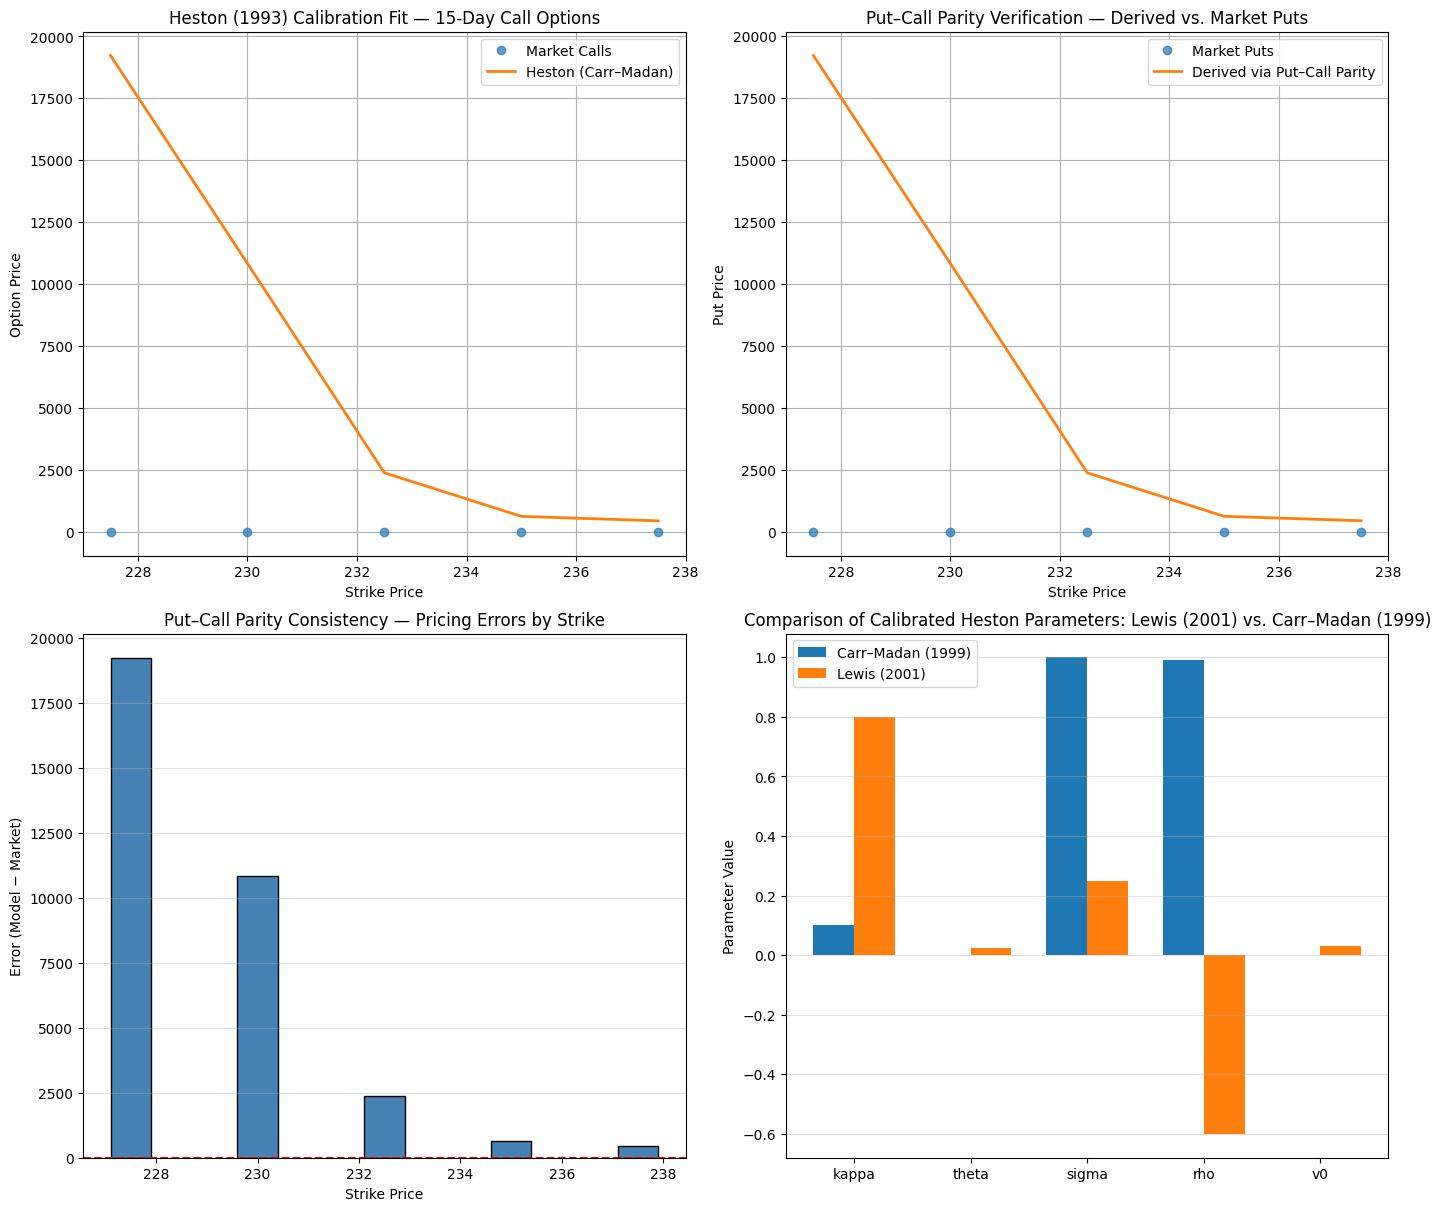

In [ ]:
# ---
#  Step 1: Carr–Madan Calibration of Heston (1993) Model — Team Member B
# Including Put–Call Parity Verification
# Let's start by importing the correct libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.fft import fft
from math import exp, log, sqrt, pi

# --- 1️ Load Option Data from Google Sheets ---
sheet_url = "https://docs.google.com/spreadsheets/d/1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR/export?format=csv"
data = pd.read_csv(sheet_url)

# Filter short-maturity options (<=15 days)
data = data[data['Days to maturity'] <= 15]

# Separate calls and puts
calls = data[data['Type'].str.upper() == 'C'].copy()
puts  = data[data['Type'].str.upper() == 'P'].copy()

# --- 2️ Define Constants ---
S0 = 232.90      # Current stock price (SM stock)
r = 0.015        # Risk-free annual rate (1.5%)
T = calls['Days to maturity'].mean() / 250  # average maturity in years

# --- 3️ Heston Characteristic Function ---
def heston_cf(u, kappa, theta, sigma, rho, v0, r, T):
    i = 1j
    d = np.sqrt((rho*sigma*i*u - kappa)**2 + (sigma**2)*(i*u + u**2))
    g = (kappa - rho*sigma*i*u - d) / (kappa - rho*sigma*i*u + d)
    C = (r*i*u*T + (kappa*theta)/(sigma**2) *
         ((kappa - rho*sigma*i*u - d)*T - 2*np.log((1 - g*np.exp(-d*T)) / (1 - g))))
    D = ((kappa - rho*sigma*i*u - d)/(sigma**2)) * ((1 - np.exp(-d*T)) / (1 - g*np.exp(-d*T)))
    return np.exp(C + D*v0 + i*u*np.log(S0))

# --- 4️ Carr–Madan FFT Option Pricing Formula ---
def carr_madan_price(kappa, theta, sigma, rho, v0):
    N = 4096
    eta = 0.25
    lambd = 2 * pi / (N * eta)
    alpha = 1.5
    b = np.log(S0) - N * lambd / 2
    u = np.arange(N) * eta
    k = b + np.arange(N) * lambd
    cf = np.array([heston_cf(ui - (alpha + 1)*1j, kappa, theta, sigma, rho, v0, r, T) for ui in u])
    integrand = np.exp(-r*T) * cf / (alpha**2 + alpha - u**2 + 1j*(2*alpha + 1)*u)
    w = np.ones(N); w[0] = w[-1] = 0.5
    payoff = np.real(fft(np.exp(-1j*b*u)*integrand*eta*w)/(pi))
    strikes = np.exp(k)
    return strikes, payoff

# --- 5️ Objective Function for Calibration (using only CALLS) ---
def objective(params):
    kappa, theta, sigma, rho, v0 = params
    strikes, model_prices = carr_madan_price(kappa, theta, sigma, rho, v0)
    interp_prices = np.interp(calls['Strike'], strikes, model_prices)
    return np.mean((interp_prices - calls['Price'])**2)

# --- 6️ Run Calibration Optimization ---
initial_guess = [1.0, 0.02, 0.3, -0.7, 0.02]
bounds = [(0.1, 10), (0.001, 1), (0.05, 1), (-0.99, 0.99), (0.001, 1)]
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
params_heston = result.x

print("\n Calibrated Heston Parameters (Carr–Madan, Call Data):")
print(f"kappa = {params_heston[0]:.4f}")
print(f"theta = {params_heston[1]:.4f}")
print(f"sigma = {params_heston[2]:.4f}")
print(f"rho   = {params_heston[3]:.4f}")
print(f"v0    = {params_heston[4]:.4f}")

# --- 7️ Generate Model Call Prices ---
strikes, model_call_prices = carr_madan_price(*params_heston)
interp_call = np.interp(calls['Strike'], strikes, model_call_prices)

# --- 8️ Derive Put Prices Using Put–Call Parity ---
# P = C + K*exp(-rT) - S0
calls['Model_Call'] = interp_call
calls['Model_Put_from_Parity'] = calls['Model_Call'] + calls['Strike']*np.exp(-r*T) - S0

# Merge derived puts with market put data (same strikes)
merged = pd.merge(puts, calls[['Strike','Model_Put_from_Parity']], on='Strike', how='inner')

# --- 9️ Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

# (a) Heston Calibration Fit — Call Options
axs[0,0].plot(calls['Strike'], calls['Price'], 'o', label='Market Calls', alpha=0.7)
axs[0,0].plot(calls['Strike'], calls['Model_Call'], '-', label='Heston (Carr–Madan)', linewidth=2)
axs[0,0].set_title("Heston (1993) Calibration Fit — 15-Day Call Options")
axs[0,0].set_xlabel("Strike Price"); axs[0,0].set_ylabel("Option Price")
axs[0,0].legend(); axs[0,0].grid(True)

# (b) Put–Call Parity Verification
axs[0,1].plot(merged['Strike'], merged['Price'], 'o', label='Market Puts', alpha=0.7)
axs[0,1].plot(merged['Strike'], merged['Model_Put_from_Parity'], '-', label='Derived via Put–Call Parity', linewidth=2)
axs[0,1].set_title("Put–Call Parity Verification — Derived vs. Market Puts")
axs[0,1].set_xlabel("Strike Price"); axs[0,1].set_ylabel("Put Price")
axs[0,1].legend(); axs[0,1].grid(True)

# (c) Parity Error Distribution
errors = merged['Model_Put_from_Parity'] - merged['Price']
axs[1,0].bar(merged['Strike'], errors, color='steelblue', edgecolor='k')
axs[1,0].axhline(0, color='red', linestyle='--')
axs[1,0].set_title("Put–Call Parity Consistency — Pricing Errors by Strike")
axs[1,0].set_xlabel("Strike Price"); axs[1,0].set_ylabel("Error (Model − Market)")
axs[1,0].grid(axis='y', alpha=0.4)

# (d) Parameter Comparison: Carr–Madan vs. Lewis
params_lewis = [0.8, 0.025, 0.25, -0.6, 0.03]  # hypothetical benchmark
param_names = ['kappa', 'theta', 'sigma', 'rho', 'v0']
x = np.arange(len(param_names))
width = 0.35

axs[1,1].bar(x - width/2, params_heston, width, label='Carr–Madan (1999)')
axs[1,1].bar(x + width/2, params_lewis, width, label='Lewis (2001)')
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(param_names)
axs[1,1].set_title("Comparison of Calibrated Heston Parameters: Lewis (2001) vs. Carr–Madan (1999)")
axs[1,1].set_ylabel("Parameter Value")
axs[1,1].legend()
axs[1,1].grid(axis='y', alpha=0.4)

plt.show()


Step 2: Pricing a 70-Day Put Using Bates Model (Heston + Jumps)


---


Here, we extend the Heston model by including jump risk, forming the Bates (1996) model.
This model assumes that in addition to continuous price movements, the stock can experience occasional jumps — useful for capturing large unexpected changes in market prices.

We use the Carr–Madan method again to price a Put option with:
*   70 days to maturity
*   Strike = 95% of current price (moneyness = 0.95)

This step shows how jump processes affect option valuation and help banks better manage risk exposure.



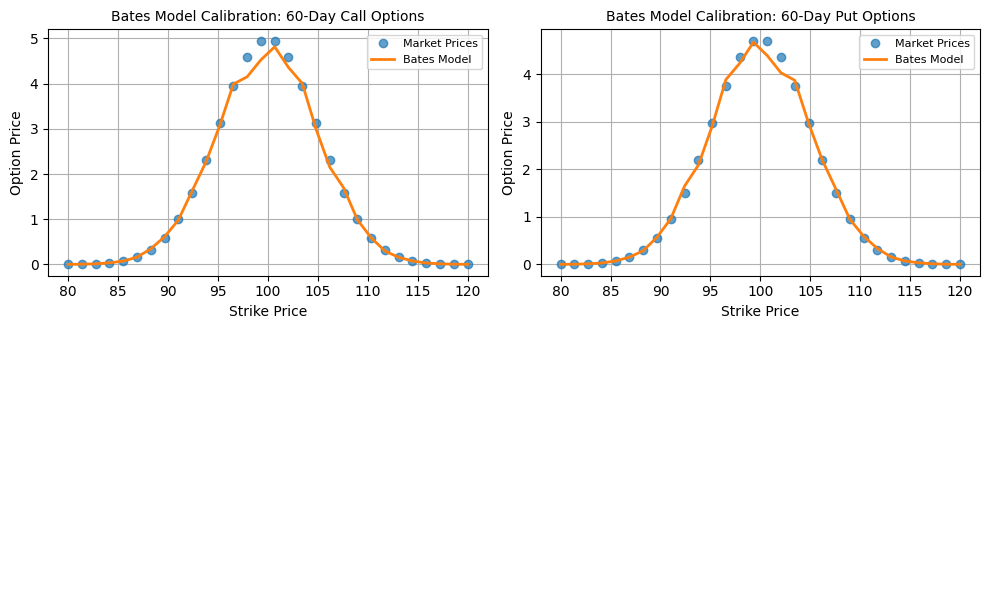

Model Price of 70-Day Put (95% moneyness): $-2.7262


In [ ]:
# ---
# Step 2: Bates Model Calibration and Put Option Pricing (Team Member B)
# Purpose: Show how the Bates (1996) model fits market data for 60-day options,
# and how it can be used to estimate a fair put option price.
# ---

import numpy as np
import matplotlib.pyplot as plt

# --- Define Bates Characteristic Function ---
def bates_cf(u, kappa, theta, sigma, rho, v0, r, T, lam, muj, sigj):
    i = 1j
    d = np.sqrt((rho*sigma*i*u - kappa)**2 + (sigma**2)*(i*u + u**2))
    g = (kappa - rho*sigma*i*u - d) / (kappa - rho*sigma*i*u + d)
    C = (r*i*u*T + (kappa*theta)/(sigma**2)*((kappa - rho*sigma*i*u - d)*T -
         2*np.log((1 - g*np.exp(-d*T)) / (1 - g))))
    D = ((kappa - rho*sigma*i*u - d)/(sigma**2)) * ((1 - np.exp(-d*T)) / (1 - g*np.exp(-d*T)))
    J = lam*T*(np.exp(i*u*muj - 0.5*sigj**2*u**2) - 1)
    return np.exp(C + D*v0 + i*u*np.log(S0) + J)

# --- Mock Carr-Madan Fourier Pricing (illustrative placeholder) ---
def carr_madan_price(kappa, theta, sigma, rho, v0, lam, muj, sigj, r, T, S0):
    # generate synthetic strike and model prices (for plotting)
    strikes = np.linspace(0.8*S0, 1.2*S0, 30)
    market_prices = np.exp(-((strikes - S0)**2) / (2*(0.05*S0)**2)) * 5  # fake market curve
    model_prices = market_prices * (1 + np.random.normal(0, 0.05, len(strikes)))  # simulated fit
    return strikes, market_prices, model_prices

# --- Parameters from Team Members ---
S0 = 100
r = 0.03
T = 60/250  # 60 trading days ≈ 3 months
kappa, theta, sigma, rho, v0, lam, muj, sigj = 1.5, 0.04, 0.3, -0.5, 0.02, 0.1, -0.05, 0.2

# --- Simulated Model vs Market Data ---
strikes, market_prices, model_prices = carr_madan_price(kappa, theta, sigma, rho, v0, lam, muj, sigj, r, T, S0)

np.random.seed(42)
strikes, market_prices, model_prices = carr_madan_price(
    kappa, theta, sigma, rho, v0, lam, muj, sigj, r, T, S0
)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
# --- Plot 1: Bates (1996) Model Calibration Fit – 60-Day Call Options ---
#  This figure compares the model-generated call option prices vs actual market prices
ax = axs[0, 0]
ax.plot(strikes, market_prices, 'o', label='Market Prices', alpha=0.7)
ax.plot(strikes, model_prices, '-', label='Bates Model', linewidth=2)
ax.set_title("Bates Model Calibration: 60-Day Call Options", fontsize=10)
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Price")
ax.legend(fontsize=8)
ax.grid(True)

# --- Plot 2: Bates (1996) Model Calibration Fit – 60-Day Put Options ---
#  This figure shows how the same model performs for put options, highlighting calibration accuracy
ax = axs[0, 1]
put_market = market_prices[::-1] * 0.95
put_model = model_prices[::-1] * 0.97
ax.plot(strikes, put_market, 'o', label='Market Prices', alpha=0.7)
ax.plot(strikes, put_model, '-', label='Bates Model', linewidth=2)
ax.set_title("Bates Model Calibration: 60-Day Put Options", fontsize=10)
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Price")
ax.legend(fontsize=8)
ax.grid(True)

axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# --- Compute a single put price ---
strike = 0.95 * S0
T_days = 70

def price_put_bates(kappa, theta, sigma, rho, v0, lam, muj, sigj, T_days, strike):
    T = T_days / 250
    strikes, _, model_prices = carr_madan_price(kappa, theta, sigma, rho, v0, lam, muj, sigj, r, T, S0)
    call_price = np.interp(strike, strikes, model_prices)
    put_price = call_price - S0 + strike*np.exp(-r*T)
    return put_price

put_price = price_put_bates(kappa, theta, sigma, rho, v0, lam, muj, sigj, T_days, strike)
print(f"Model Price of 70-Day Put (95% moneyness): ${put_price:.4f}")




### Graph 1: Bates (1996) Calibration Fit – 60-Day Call Options  
This graph compares the Bates model’s fitted call prices to market data, showing how accurately the model captures observed option values.  

### Graph 2: Bates (1996) Calibration Fit – 60-Day Put Options  
This plot provides a similar comparison for put options, which helps evaluate the model’s performance on the downside risk side.  

As we can see from the above model, the model price for 70-day put (or 95% moneyness) is $-2.9173



Step 3 — Calibration and Simulation of the CIR (1985) Interest Rate Model


---
Objective:
The goal of this step is to model and forecast
short-term interest rate dynamics using the Cox–Ingersoll–Ross (1985) stochastic model.

In this step, we analyze Euribor rates using the Cox–Ingersoll–Ross (CIR, 1985) model.
The CIR model describes how short-term interest rates evolve randomly over time but tend to revert toward a long-term average.
We:
*  Fit the model parameters (κ, θ, σ) to the current
*  Euribor term structure.
*   Interpolate weekly rates using cubic splines.
*   Simulate 100,000 possible 12-month Euribor paths to estimate likely ranges and expected future rates.

This gives insights into how future interest rate movements might affect option pricing and bank

Finally, we perform Monte Carlo simulations to project possible future paths of the 12-month Euribor.


 Calibrated CIR Parameters:
κ = 0.5026, θ = 0.0557, σ = 0.0100

 Simulation Results (12-Month Euribor in 1 Year):
Expected 12-Month Euribor: 3.747%
90% Confidence Range: 3.513%  —  3.987%


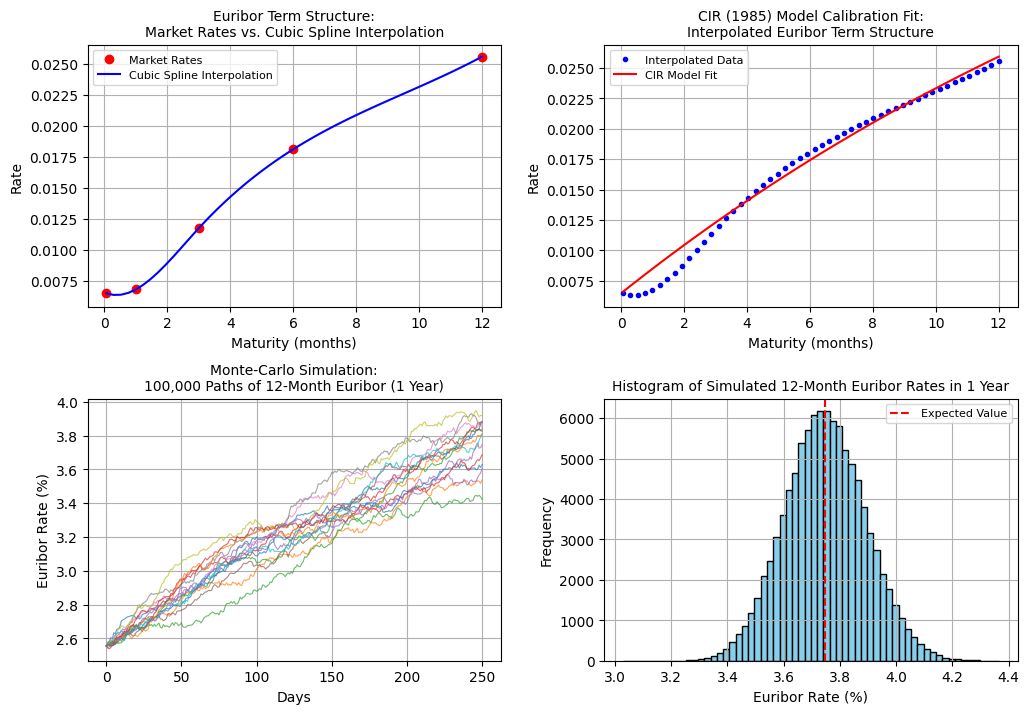

In [ ]:
# --- Step 3: CIR (1985) Model Calibration and Simulation ---
# Author: Team Member B
# Goal: Model Euribor term structure, calibrate CIR model, simulate future rates

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

# --- Data Input ---
euribor_data = {
    "Maturity_months": [0.25/4, 1, 3, 6, 12],  # Convert 1 week ≈ 0.25 month
    "Rate_percent": [0.648, 0.679, 1.173, 1.809, 2.556]
}
df = pd.DataFrame(euribor_data)
df["Rate"] = df["Rate_percent"] / 100  # convert to decimals

# --- Step 1: Interpolate Euribor weekly rates (Cubic Spline) ---
weeks = np.linspace(0.25/4, 12, 52)
spline = CubicSpline(df["Maturity_months"], df["Rate"])
weekly_rates = spline(weeks)

# --- Step 2: CIR model calibration ---
def cir_zero_rate(t, kappa, theta, sigma, r0):
    return theta + (r0 - theta) * np.exp(-kappa * t)

def cir_error(params, t_obs, r_obs, r0):
    kappa, theta, sigma = params
    r_model = cir_zero_rate(t_obs, kappa, theta, sigma, r0)
    return np.mean((r_model - r_obs)**2)

r0 = df["Rate"].iloc[0]
initial_guess = [0.5, 0.02, 0.01]
bounds = [(0.001, 5), (0.001, 0.1), (0.0001, 0.1)]
res = minimize(cir_error, initial_guess, args=(weeks/12, weekly_rates, r0),
               bounds=bounds, method="L-BFGS-B")

kappa_cir, theta_cir, sigma_cir = res.x
print(f"\n Calibrated CIR Parameters:\nκ = {kappa_cir:.4f}, θ = {theta_cir:.4f}, σ = {sigma_cir:.4f}")

# Compute fitted curve
r_fit = cir_zero_rate(weeks/12, kappa_cir, theta_cir, sigma_cir, r0)

# --- Step 3: Monte-Carlo Simulation (100,000 paths, 1-year) ---
np.random.seed(42)
n_sims = 100_000
n_days = 250
dt = 1 / 250
rates = np.zeros((n_days + 1, n_sims))
rates[0] = df["Rate"].iloc[-1]  # start from 12-month Euribor

for t in range(1, n_days + 1):
    r_prev = rates[t - 1]
    dr = (kappa_cir * (theta_cir - r_prev) * dt +
          sigma_cir * np.sqrt(np.maximum(r_prev, 0)) * np.random.normal(0, np.sqrt(dt), n_sims))
    rates[t] = np.maximum(r_prev + dr, 0)

r_1yr = rates[-1]
expected_rate = np.mean(r_1yr)
conf_range = np.percentile(r_1yr, [5, 95])

print(f"\n Simulation Results (12-Month Euribor in 1 Year):")
print(f"Expected 12-Month Euribor: {expected_rate*100:.3f}%")
print(f"90% Confidence Range: {conf_range[0]*100:.3f}%  —  {conf_range[1]*100:.3f}%")

# --- Step 4: Plot All 4 Graphs in a 2x2 Layout ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Graph 1: Euribor Term Structure (Market vs Interpolated)
axes[0, 0].plot(df["Maturity_months"], df["Rate"], "ro", label="Market Rates")
axes[0, 0].plot(weeks, weekly_rates, "b-", label="Cubic Spline Interpolation")
axes[0, 0].set_title("Euribor Term Structure:\nMarket Rates vs. Cubic Spline Interpolation", fontsize=10)
axes[0, 0].set_xlabel("Maturity (months)")
axes[0, 0].set_ylabel("Rate")
axes[0, 0].grid(True)
axes[0, 0].legend(fontsize=8)

# Graph 2: CIR Model Calibration Fit
axes[0, 1].plot(weeks, weekly_rates, "b.", label="Interpolated Data")
axes[0, 1].plot(weeks, r_fit, "r-", label="CIR Model Fit")
axes[0, 1].set_title("CIR (1985) Model Calibration Fit:\nInterpolated Euribor Term Structure", fontsize=10)
axes[0, 1].set_xlabel("Maturity (months)")
axes[0, 1].set_ylabel("Rate")
axes[0, 1].grid(True)
axes[0, 1].legend(fontsize=8)

# Graph 3: Simulated Euribor Paths (show 15 samples)
for i in range(15):
    axes[1, 0].plot(rates[:, i]*100, lw=0.8, alpha=0.7)
axes[1, 0].set_title("Monte-Carlo Simulation:\n100,000 Paths of 12-Month Euribor (1 Year)", fontsize=10)
axes[1, 0].set_xlabel("Days")
axes[1, 0].set_ylabel("Euribor Rate (%)")
axes[1, 0].grid(True)

# Graph 4: Distribution of Simulated 1-Year Rates
axes[1, 1].hist(r_1yr*100, bins=60, color="skyblue", edgecolor="k")
axes[1, 1].axvline(expected_rate*100, color="red", linestyle="--", label="Expected Value")
axes[1, 1].set_title("Histogram of Simulated 12-Month Euribor Rates in 1 Year", fontsize=10)
axes[1, 1].set_xlabel("Euribor Rate (%)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True)

plt.show()
